# Анализ лояльности пользователей Яндекс Афиши

## Цели и задачи проекта

**Цель:** Команда маркетинга хочет лучше понимать поведение пользователей. Для этого требуется провести исследовательский анализ данных, чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно. Это позволит:
- Быстро выявлять перспективных клиентов и предлагать им персонализированные условия.
- Точно настраивать рекламу на аудитории с высокой вероятностью возврата.
- Оптимизировать маркетинговые бюджеты.
- Повысить общий уровень удержания клиентов.

**Задачи:**
1. **Создание профиля пользователя**
    - Построить профиль пользователя — для каждого пользователя
    - Оценить данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?
    
    
2. **Исследовательский анализ данных**
    - Исследовать признаки, описывающие первый заказ пользователя, и выяснить, влияют ли они на вероятность возвращения пользователя.  
    
    - Опираясь на выводы из задач выше, проверить продуктовые гипотезы:
        - Гипотеза 1. Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
        - Гипотеза 2. В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.
        
    - Изучить количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.
    
    - Изучите временные параметры, связанные с первым заказом пользователей:
        - день недели первой покупки;
        - время с момента первой покупки — лайфтайм;
        - средний интервал между покупками пользователей с повторными заказами.


3. **Корреляционный анализ количества покупок и признаков пользователя**
    - Изучить, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Использовать универсальный коэффициент корреляции phi_k, который позволяет анализировать как числовые, так и категориальные признаки.

## Описание данных

`user_id` — уникальный идентификатор пользователя, совершившего заказ;  

`device_type_canonical` — тип устройства, с которого был оформлен заказ ( mobile — мобильные устройства, desktop — стационарные);  

`order_id` — уникальный идентификатор заказа;  

`order_dt` — дата создания заказа (используйте данные created_dt_msk );  

`order_ts` — дата и время создания заказа (используйте данные created_ts_msk );  

`currency_code` — валюта оплаты;  

`revenue` — выручка от заказа;  

`tickets_count` — количество купленных билетов;  

`days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;

`event_id` — уникальный идентификатор мероприятия;  

`service_name` — название билетного оператора;  

`event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);  

`region_name` — название региона, в котором прошло мероприятие;  

`city_name` — название города, в котором прошло мероприятие.
___

## 1. Загрузка данных

Импортируем необходимые библиотеки, выгрузим данные.

In [1]:
!pip install psycopg2

In [2]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#загрузим данные для перевода выручки в российские рубли
df_kzt = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [4]:
#создадим словарь с необходимыми для подключения к БД данными
db_config = {'user': 'praktikum_student',
             'pwd': 'Sdf4$2;d-d30pp',
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432,
             'db': 'data-analyst-afisha'
             }

In [5]:
#создадим строку для авторизации и передадим ее в функцию create_engine
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
engine = create_engine(connection_string)

In [6]:
#запишем запрос к БД в переменную
query = """
SELECT user_id,
  device_type_canonical,
  order_id,
  created_dt_msk AS order_dt,
  created_ts_msk AS order_ts,
  currency_code,
  revenue,
  tickets_count,
  created_dt_msk::date - LAG(created_dt_msk) OVER(PARTITION BY user_id ORDER BY created_dt_msk)::date AS days_since_prev,
  event_id,
  e.event_name_code AS event_name,
  e.event_type_main,
  service_name,
  r.region_name,
  c.city_name
FROM afisha.purchases p 
INNER JOIN afisha.events e USING(event_id)
LEFT JOIN afisha.city c USING(city_id)
LEFT JOIN afisha.regions r USING(region_id)
WHERE device_type_canonical IN ('mobile','desktop') AND e.event_type_main != 'фильм'
ORDER BY user_id
"""

In [7]:
#создадим датафрейм из таблицы
df = pd.read_sql_query(query,con=engine)

Изучим общую информацию. И оценим корректность выгрузки и объём полученных данных.

In [8]:
#выведем первые строки датафрейма и общую информацию о нем
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

None

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


### 1.1 Информация о загруженных данных

**Структура данных:**
- **290,611 строк** (транзакций/заказов)
- **15 колонок** с различными атрибутами заказов

**Колонки и их типы:**
1. **user_id** — object
2. **device_type_canonical** — object
3. **order_id** — int64
4. **order_dt** — datetime64[ns]
5. **order_ts** — datetime64[ns]
6. **currency_code** — object
7. **revenue** — float64 
8. **tickets_count** — int64
9. **days_since_prev** — float64 
10. **event_id** — int64
11. **event_name** — object
12. **event_type_main** — object
13. **service_name** — object
14. **region_name** — object
15. **city_name** — object

**Заметки по данным:**
- **Есть пропуски:** колонка `days_since_prev` содержит NaN
- **Типы данных:** много текстовых колонок, которые можно оптимизировать
- **Размер:** 33.3+ MB
- **Формат:** все даты в корректном datetime формате

**Что можно улучшить:**
- Обработать пропуски в `days_since_prev`
- Оптимизировать числовые типы данных
- Привести `device_type_canonical`, `event_type_main`, `currency_code` к типу category

In [9]:
#перед обработкой зафиксируем начальный размер датафрейма
temp = df.copy()

___

## 2. Предобработка данных

Перед проведением исследовательского анализа данных, проведем их предобработку, включающую в себя:
- Проверку корректности типов данных и при необходимости их корректировку;
- Подсчет количества пропусков и их обработку;
- Выявление явных и неявных дубликатов и их удаление. 

### 2.1 Типы данных

Столбцы `device_type_canonical`, `event_type_main`, `currency_code` состоят из небольшого множества уникальных значений, приведем их к типу **сategory**.

In [10]:
#преобразуем столбцы датафрейма
df[['device_type_canonical','event_type_main','currency_code']] = df[['device_type_canonical','event_type_main','currency_code']].astype('category')

Столбцы `order_id`,`tickets_count`,`event_id` состоят из коротких числовых комбинаций, понизим их разрядность.

In [11]:
#понизим разрядность столбцов
for i in df[['order_id','tickets_count','event_id']]:
    df[i] = pd.to_numeric(df[i],downcast='integer')

После обработки пропусков в столбце `days_since_prev` приведем данный столбец к int.

### 2.2 Пропуски

In [12]:
#посчитаем пропуски в абсолютных и относительных значениях
df_pass = pd.DataFrame({'Количество пропусков' : df.isna().sum(), 'Доля пропусков' : round(df.isna().mean(),3)})
df_pass

,Количество пропусков,Доля пропусков
user_id,0,0.000
device_type_canonical,0,0.000
order_id,0,0.000
order_dt,0,0.000
order_ts,0,0.000
currency_code,0,0.000
revenue,0,0.000
tickets_count,0,0.000
days_since_prev,21933,0.075
event_id,0,0.000


In [13]:
#заполним пропуски значением 0
df['days_since_prev'] = df['days_since_prev'].fillna(0)

In [14]:
#приведем days_since_prev к типу int
df['days_since_prev'] = pd.to_numeric(df['days_since_prev'],downcast='integer')

### 2.3 Дубликаты

In [15]:
#посчитаем дубликаты
df.duplicated().sum()

0

Явные дубликаты отсутствуют, значения категорий не имеют неявных дубликатов. 

### 2.4 Приведение выручки к одной валюте

Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведем выручку к единой валюте — российскому рублю.
Для этого используем датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — final_tickets_tenge_df.csv. Значения в рублях представлено для 100 тенге.
Результаты преобразования сохраним в новый столбец `revenue_rub`.

In [16]:
#среднее по курсу тенге
kzt_m = df_kzt['curs'].mean()

In [17]:
#создадим функцию для подсчета выручки в рублях
def rub_kzt(row,mean=kzt_m):
    """
    функция для конвертации тенге в рубли
    """
    if row['currency_code'] == 'rub':
        return row['revenue']
    else:
        return round(row['revenue'] * (mean/100),2)

In [18]:
#добавим новый столбец с конвертированной выручкой
df['revenue_rub'] = df.apply(rub_kzt,axis=1)

### 2.5 Анализ числовых столбцов

Проверим распределение численных данных и наличие в них выбросов. Для этого отобразим статистические показатели, гистограммы распределения значений и диаграммы размаха.

In [19]:
#основные статистики столбцов revenue_rub,tickets_count
df[['revenue_rub','tickets_count','days_since_prev']].describe()

,revenue_rub,tickets_count,days_since_prev
count,290611.000000,290611.000000,290611.000000
mean,555.668237,2.754311,2.979182
std,875.469745,1.170620,10.946927
min,-90.760000,1.000000,0.000000
25%,113.970000,2.000000,0.000000
50%,351.870000,3.000000,0.000000
75%,802.050000,4.000000,1.000000
max,81174.540000,57.000000,148.000000


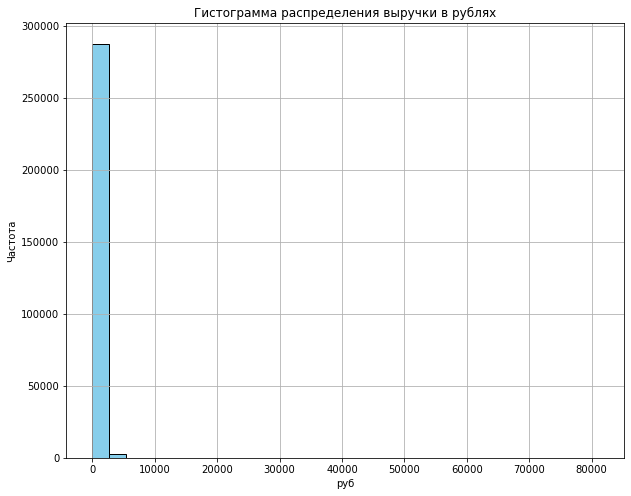

In [20]:
#гистрограмма распределения revenue_rub
df.hist(column='revenue_rub',bins=30,figsize=(10,8),color='skyblue',edgecolor='black')
plt.title('Гистограмма распределения выручки в рублях')
plt.xlabel('руб')
plt.ylabel('Частота')
plt.show()

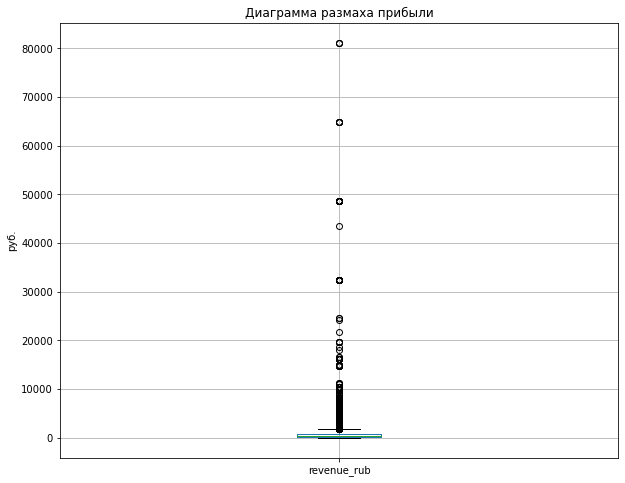

In [21]:
#диаграмма размаха для revenue_rub
df.boxplot(column='revenue_rub',figsize=(10,8))
plt.ylabel('руб.')
plt.title('Диаграмма размаха прибыли')
plt.show()

В распределении выручки обнаружены выбросы, отфильтруем данные по 99 процентилю и отрицательные значения выручки.

In [22]:
#создадим новый датафрейм со скоректированными значениями
df = df[(df['revenue_rub'] <= df['revenue_rub'].quantile(0.99)) & (df['revenue_rub'] > 0)].copy()

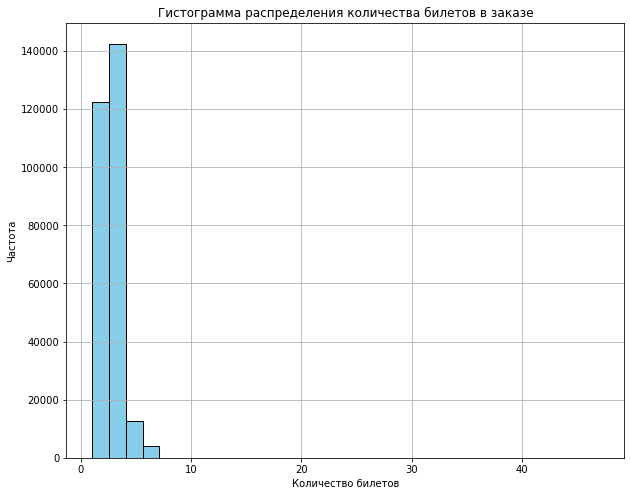

In [23]:
#гистрограмма количества билетов
df.hist(column='tickets_count',bins=30,figsize=(10,8),color='skyblue',edgecolor='black')
plt.title('Гистограмма распределения количества билетов в заказе')
plt.xlabel('Количество билетов')
plt.ylabel('Частота')
plt.show()

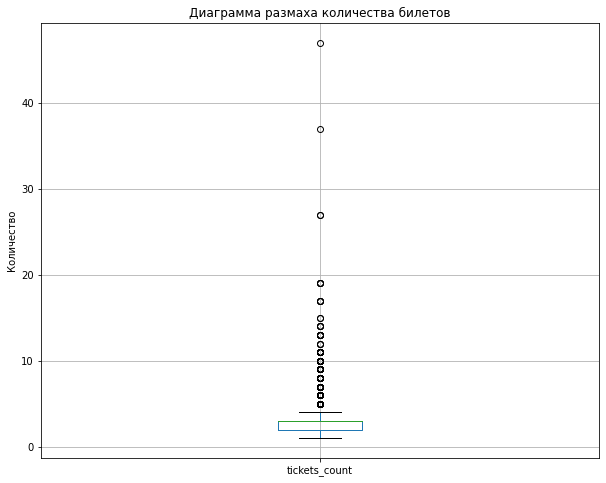

In [24]:
#диаграмма размаха для tickets_count
df.boxplot(column='tickets_count',figsize=(10,8))
plt.title('Диаграмма размаха количества билетов')
plt.ylabel('Количество')
plt.show()

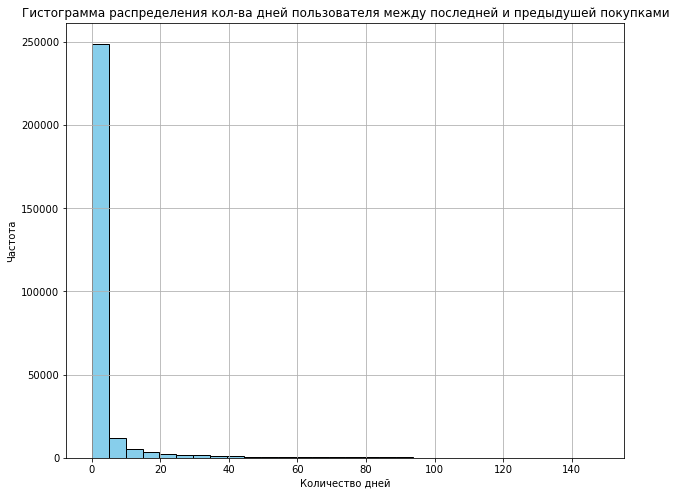

In [25]:
#гистограмма для days_since_prev
df.hist(column='days_since_prev',bins=30,figsize=(10,8),color='skyblue',edgecolor='black')
plt.title('Гистограмма распределения кол-ва дней пользователя между последней и предыдушей покупками')
plt.xlabel('Количество дней')
plt.ylabel('Частота')
plt.show()

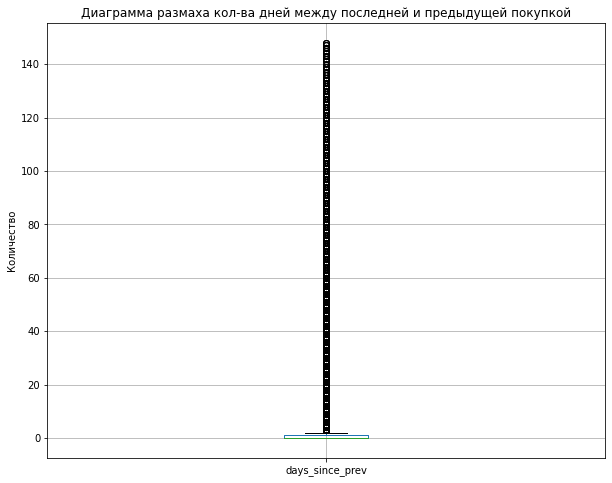

In [26]:
#диаграмма размаха days_since_prev
df.boxplot(column='days_since_prev',figsize=(10,8))
plt.title('Диаграмма размаха кол-ва дней между последней и предыдущей покупкой')
plt.ylabel('Количество')
plt.show()

In [27]:
print(f'Начальный размер датафрейма: {temp.shape[0]}.\nПосле предобработки данных {df.shape[0]}.\nДоля удаленных данных {1 - df.shape[0]/temp.shape[0]}')

Начальный размер датафрейма: 290611.
После предобработки данных 281834.
Доля удаленных данных 0.03020188499402987


### 2.6 Вывод по предобработке данных

**1. Корректировка типов данных**
- Столбцы `device_type_canonical`, `event_type_main`, `currency_code` преобразованы в тип **`category`**, так как содержат ограниченное множество уникальных значений
- Столбцы `order_id`, `tickets_count`, `event_id` содержат короткие числовые комбинации — применено понижение разрядности через `pd.to_numeric(..., downcast='integer')` для оптимизации использования памяти
- После заполнения пропусков в столбце `days_since_prev` он приведен к целочисленному типу (`int`)

**2. Обработка пропущенных значений**
- Проанализированы все столбцы на наличие пропусков: единственный столбец с пропусками — `days_since_prev`
- Количество пропусков: **21,933** (составляет **7.5%** от общего объема данных)
- Пропущенные значения заполнены значением **`0`** — это соответствует интерпретации, что у пользователя не было предыдущей покупки (первая покупка в истории)

**3. Проверка на дубликаты**
- Проверены явные дубликаты строк с помощью `df.duplicated().sum()` — результат **`0`**, полные дубликаты отсутствуют
- Проверены неявные дубликаты в категориальных данных — неявные дубликаты не обнаружены

**4. Приведение выручки к единой валюте**
- Исходные данные содержат выручку в двух валютах: российский рубль (`rub`) и казахстанский тенге (`kzt`)
- Использован дополнительный датасет с курсами тенге за 2024 год (`final_tickets_tenge_df.csv`)
- Рассчитан средний курс: `kzt_m = df_kzt['curs'].mean()`
- Создана функция `rub_kzt()` для конвертации: если валюта `rub` — возвращается исходное значение, если `kzt` — применяется формула `row['revenue'] * (mean/100)`
- Добавлен новый столбец `revenue_rub` с выручкой, приведенной к российским рублям

**5. Анализ числовых столбцов и обработка выбросов**
- Проведен статистический анализ столбцов `revenue_rub`, `tickets_count`, `days_since_prev` с помощью `.describe()`
- Построены гистограммы распределения и диаграммы размаха (boxplot) для визуальной оценки распределений и выявления выбросов

**Для `revenue_rub` (выручка в рублях):**
- Среднее значение: **555.67**, медиана: **351.87**, стандартное отклонение: **875.47**
- Минимальное значение: **-90.76**, максимальное: **81,174.54**
- Обнаружены отрицательные значения и экстремальные выбросы
- Применена фильтрация: удалены отрицательные значения и значения выше **99-го процентиля**

**Для `tickets_count` (количество билетов в заказе):**
- Среднее значение: **2.75**, медиана: **3**, стандартное отклонение: **1.17**
- Минимальное значение: **1**, максимальное: **57**
- Распределение близко к нормальному, выбросы незначительны

**Для `days_since_prev` (дней с предыдущей покупки):**
- Среднее значение: **2.98**, медиана: **0**, стандартное отклонение: **10.95**
- Минимальное значение: **0**, максимальное: **148**
- Распределение сильно смещено в сторону 0, что характерно для данных о покупках (много первых покупок или частых повторных покупок)

**6. Итоговые результаты предобработки**
- Начальный размер датафрейма: **290,611 строк**
- Конечный размер датафрейма после обработки: **281,834 строк**
- Количество удаленных строк: **8,777 строк**
- Доля удаленных данных: **≈3.02%**

**7. Заключение**
Все запланированные этапы предобработки данных выполнены:
- Типы данных скорректированы и оптимизированы
- Пропущенные значения обработаны
- Дубликаты проверены
- Выручка приведена к единой валюте
- Проведен анализ распределений числовых переменных
- Выявлены и обработаны аномальные значения в выручке
- Данные готовы для проведения исследовательского анализа.
___

## 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Для этого требуется построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

In [47]:
#отсортируем датафрейм по дате заказа
df_sort = df.sort_values('order_dt')

Для каждого пользователя найдем:
* дату первого и последнего заказа;
* устройство, с которого был сделан первый заказ;
* регион, в котором был сделан первый заказ;
* билетного партнёра, к которому обращались при первом заказе;
* жанр первого посещённого мероприятия (используйте поле event_type_main );
* общее количество заказов;
* средняя выручка с одного заказа в рублях;
* среднее количество билетов в заказе;
* среднее время между заказами.

In [53]:
#сгрупируем данные и агрегируем необходимые показатели
df_1 = df_sort.groupby('user_id').agg(
    first_order_dt = ('order_dt','min'),
    last_order_dt = ('order_dt','max'),
    first_order_device = ('device_type_canonical','first'),
    first_order_region = ('region_name','first'),
    first_order_service = ('service_name','first'),
    first_order_genre = ('event_type_main','first'),
    total_orders = ('order_id','count'),
    avg_revenue = ('revenue_rub','mean'),
    agv_count_tickets = ('tickets_count','mean'),
    avg_order_interval = ('days_since_prev','mean')
).reset_index()

In [55]:
#округлим показатели в столбцах со средним
round_columns = ['avg_revenue','agv_count_tickets','avg_order_interval']
df_1[round_columns] = df_1[round_columns].round(3)

Так же требуется добавить два бинарных признака:  
`is_two` — совершил ли пользователь 2 и более заказа;  
`is_five` — совершил ли пользователь 5 и более заказов

In [62]:
#первый признак
df_1['is_two'] = (df_1['total_orders'] >= 2).astype('int')

In [63]:
#второй признак
df_1['is_five'] = (df_1['total_orders'] >= 5).astype('int')

In [61]:
#выведем первые 10 строк датафрейма для ознакомления
df_1.head(10)

,user_id,first_order_dt,last_order_dt,first_order_device,first_order_region,first_order_service,first_order_genre,total_orders,avg_revenue,agv_count_tickets,avg_order_interval,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940,4.000,0.000,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010,3.000,37.500,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213,2.667,34.000,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830,4.000,0.000,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310,1.500,8.000,1,0
5,000cf0659a9f40f,2024-06-20,2024-06-21,mobile,Широковская область,Лови билет!,концерты,13,1175.808,3.308,0.077,1,1
6,00147c9209d45d3,2024-06-25,2024-06-25,mobile,Каменевский регион,Облачко,концерты,2,352.945,1.500,0.000,1,0
7,00199a573901564,2024-06-17,2024-06-17,mobile,Каменевский регион,Билеты без проблем,концерты,1,588.120,4.000,0.000,0,0
8,001e7037d013f0f,2024-07-04,2024-09-29,mobile,Златопольский округ,Мой билет,другое,3,326.623,1.333,29.000,1,0
9,0020c5654c92ec1,2024-07-02,2024-07-02,mobile,Каменевский регион,Билеты без проблем,концерты,2,193.420,2.000,0.000,1,0
